# Part 3: Thermal Coupling

In [1]:
import os # test commit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.interpolate import interp2d

try:  # if running with Google Colab
    from google.colab import drive
    drive.mount('/content/drive')

    import sys
    # the location where you saved the tools.py and csv files
    drive_dir = '/content/drive/My Drive/Colab Notebooks/FCTT 3'
    sys.path.insert(0, drive_dir)

    data_dir =os.path.join(drive_dir, 'battery_experimental_data')
except:  # if running locally
    data_dir = os.path.abspath('battery_experimental_data')
    
from tools import *

## Load data

In [2]:
training_data_20 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_20.csv'))
SOC_OCV_data = pd.read_csv(os.path.join(data_dir, 'SOC_OCV_MFCTT_2019.csv'), sep='\t')

display(training_data_20.head())

,Time (s),Current (A),Voltage (V)
0,0.000000,0.0,4.2
1,1.000005,0.0,4.2
2,1.999999,0.0,4.2
3,3.000004,0.0,4.2
4,3.999998,0.0,4.2


In [3]:
# extract values in numpy array
ref_SOC = SOC_OCV_data['SOC'].values                   # unit in %
ref_OCV = SOC_OCV_data['Ecell/V'].values               # unit in V

t = training_data_20['Time (s)'].values                # unit in s
I = -training_data_20['Current (A)'].values             # unit in A
V_actual = training_data_20['Voltage (V)'].values      # unit in V

SOC_levels = np.arange(0.9, 0.1, -0.1)
SOC_from_idx_map = {i: SOC_levels[i] for i in range(8)}  # 8 SOC levels

## Splitting pulses

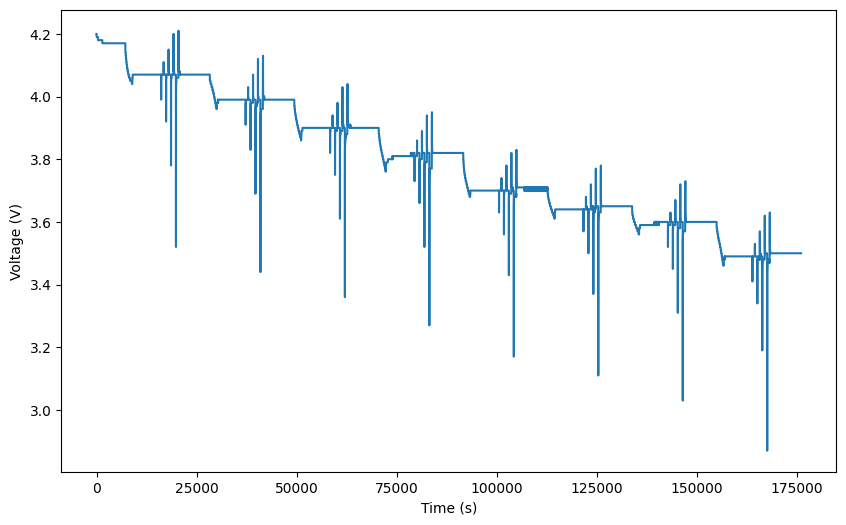

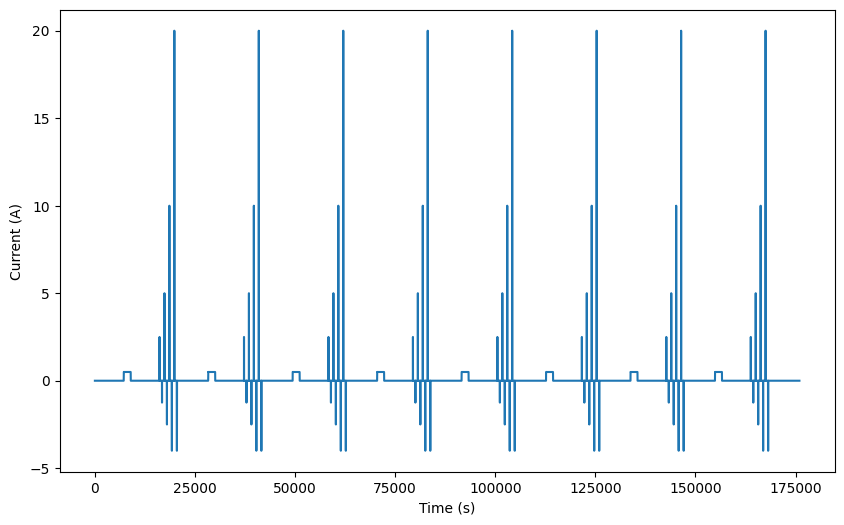

In [4]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, V_actual)
# ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')

_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, I)
# ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (A)')

plt.show()

In [5]:
# shift to left by one index (now i is equivalent to i+1)
I_shifted = np.concatenate((I[1:], [0]))
idx_pulse_start = np.flatnonzero((I == 0) & (np.abs(I_shifted) > 1))
idx_pulse_end = np.flatnonzero((np.abs(I) > 1) & (I_shifted == 0)) + 1

# reshape to 8 x 8 matrix, where rows correspond to each SOC value and
#                                cols correspond to each pulse with different current
idx_pulse_start = idx_pulse_start.reshape(8, 8)
idx_pulse_end = idx_pulse_end.reshape(8, 8)
# print(idx_pulse_start)
# print(idx_pulse_end)

to get the starting positions for all SOC values:

idx_pulse_start[:, 0]

## A bit visulisation (not part of the answer):

For each SOC value, we will have:

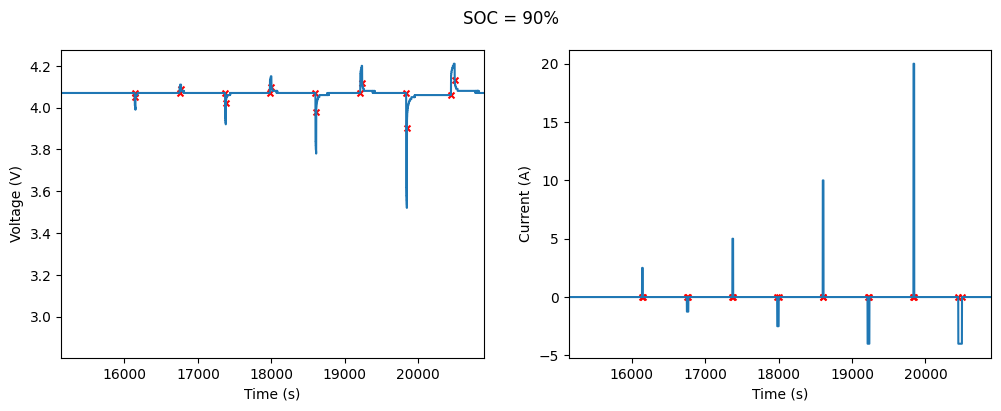

In [6]:
show_SOC = 1  # which_SOC_to_inspect, 1 represent the first cluster
SOC_level = SOC_from_idx_map[show_SOC-1]

xlim = [t[idx_pulse_start[show_SOC-1, 0] - 1000], 
        t[idx_pulse_end[show_SOC-1, -1] + 4000]]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(t, V_actual)
axes[0].scatter(t[idx_pulse_start], V_actual[idx_pulse_start], c='r',s=18, marker='x')
axes[0].scatter(t[idx_pulse_end], V_actual[idx_pulse_end], c='r',s=18, marker='x')
axes[0].set_xlim(xlim)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Voltage (V)')

axes[1].plot(t, I)
axes[1].scatter(t[idx_pulse_start], I[idx_pulse_start], c='r',s=18, marker='x')
axes[1].scatter(t[idx_pulse_end], I[idx_pulse_end], c='r',s=18, marker='x')
axes[1].set_xlim(xlim)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Current (A)')

fig.suptitle('SOC = {:0.0f}%'.format(SOC_level*100))
plt.show()

Further zoom in:

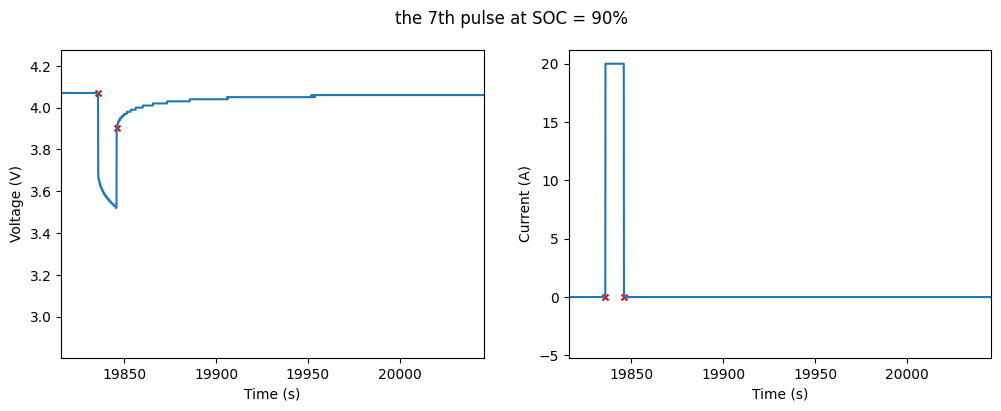

In [7]:
show_SOC = 1  # which_SOC_to_inspect
show_pulse = 7  # which_pulse_to_inspect
SOC_level = SOC_from_idx_map[show_SOC-1]

xlim = [t[idx_pulse_start[show_SOC-1, show_pulse-1] - 200],
        t[idx_pulse_end[show_SOC-1, show_pulse-1] + 2000]]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(t, V_actual)
axes[0].scatter(t[idx_pulse_start], V_actual[idx_pulse_start], c='r',s=18, marker='x')
axes[0].scatter(t[idx_pulse_end], V_actual[idx_pulse_end], c='r',s=18, marker='x')
axes[0].set_xlim(xlim)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Voltage (V)')

axes[1].plot(t, I)
axes[1].scatter(t[idx_pulse_start], I[idx_pulse_start], c='r',s=18, marker='x')
axes[1].scatter(t[idx_pulse_end], I[idx_pulse_end], c='r',s=18, marker='x')
axes[1].set_xlim(xlim)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Current (A)')

fig.suptitle('the {}th pulse at SOC = {:0.0f}%'.format(show_pulse,
                                                       SOC_level*100))
plt.show()

idx_pulse_start and idx_pulse_end identify the position where the current pulse start and finish. For the voltage, it needs some times to rest and recover to zero.

Therefore, to split the overall graph for different pulses, only idx_pulse_start is used. idx_pulse_end can be used to do parametrisation (see later).


### Find index of steady-state voltage for each pulse

In [8]:
idx_Vss = []
all_ends = idx_pulse_end.flatten()
for pos in range(len(all_ends)):
    i = 0
    while True:
        # if observing num_criteria of constant values, steady state is reached
        num_criteria = 500
        segment = V_actual[all_ends[pos]+i : all_ends[pos]+i+num_criteria] 
        if np.all(segment == segment[0]):  # all element in this array are the same
            idx_Vss.append(all_ends[pos]+i)
            break
        i += 1
        
        # Stop browsing if touching the next next pulse
        i_limit = np.concatenate((idx_pulse_start.flatten()[1:], [len(t)]))
        if i > i_limit[pos]:
            which_SOC = pos//8
            SOC_level = SOC_from_idx_map[which_SOC]
            msg = "Position of V_ss is not found for the {}th pulse at SOC = {:0.0f}%".format(pos%8, SOC_level*100)
            raise ValueError(msg)
        
idx_Vss = np.reshape(idx_Vss, [8, 8])

Plot the steady-state voltage of each pulse:

In [9]:
def plot_Vss(t, V, idx_pulse_start, idx_pulse_end, idx_Vss, 
             SOC, pulse):
    SOC_level = SOC_from_idx_map[SOC-1]
    if pulse == 'all':
        xlim = [t[idx_pulse_start[SOC-1, 0] - 300], 
                t[idx_Vss[SOC-1, -1] + 4000]]
        ylim = [np.min(V[idx_pulse_start[SOC-1, 0]:idx_Vss[SOC-1, -1]])-0.05, 
                np.max(V[idx_pulse_start[SOC-1, 0]:idx_Vss[SOC-1, -1]])+0.05]
        title = 'SOC = {:0.0f}%'.format(SOC_level*100)
    else:
        xlim = [t[idx_pulse_start[SOC-1, pulse-1] - 200],
                t[idx_Vss[SOC-1, pulse-1] + 2000]]
        ylim = [np.min(V[idx_pulse_start[SOC-1, pulse-1]:idx_Vss[SOC-1, pulse-1]])-0.05, 
                np.max(V[idx_pulse_start[SOC-1, pulse-1]:idx_Vss[SOC-1, pulse-1]])+0.05]
        title = 'the {}th pulse at SOC = {:0.0f}%'.format(pulse,
                                                          SOC_level*100)

    _, ax = plt.subplots(figsize=(10, 4))
    ax.plot(t, V)
    ax.scatter(t[idx_pulse_start], V_actual[idx_pulse_start], 
               c='r',s=20, marker='x', label='Pulse start/end')
    ax.scatter(t[idx_pulse_end], V_actual[idx_pulse_end],
               c='r',s=20, marker='x')
    ax.scatter(t[idx_Vss], V_actual[idx_Vss],
               c='g',s=20, marker='x', label='Steady State Voltage')
    
    ax.legend()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (V)')

    ax.set_title(title)
    plt.show()

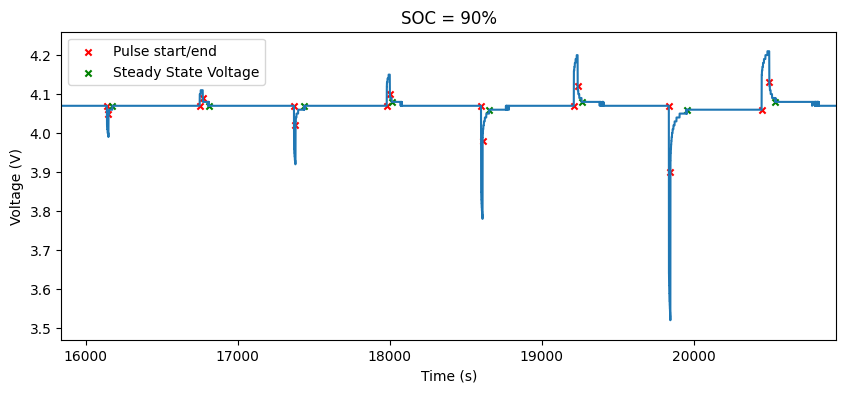

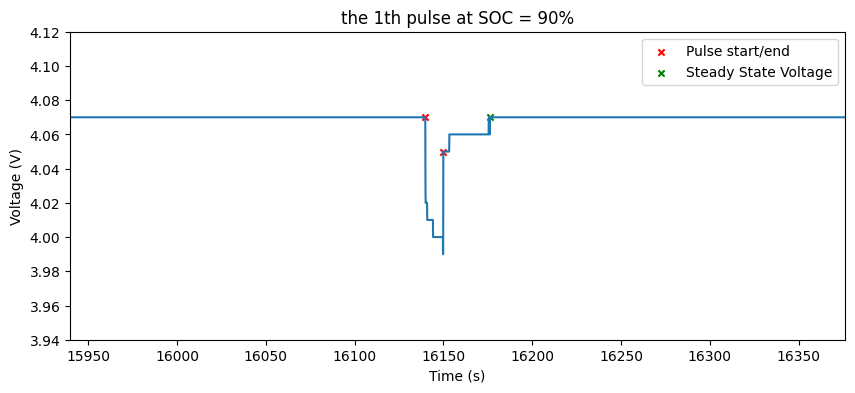

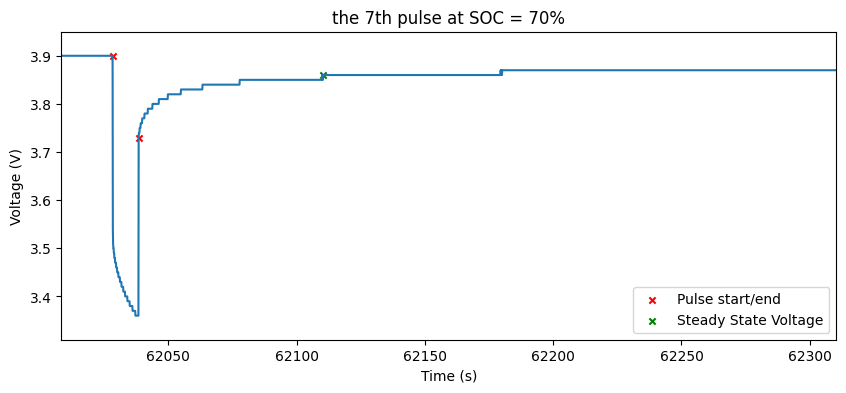

In [10]:
which_SOC_to_show = 1
which_pulse_to_show = 'all'
plot_Vss(t, V_actual, idx_pulse_start, idx_pulse_end, idx_Vss, 
         which_SOC_to_show, which_pulse_to_show)

which_SOC_to_show = 1
which_pulse_to_show = 1
plot_Vss(t, V_actual, idx_pulse_start, idx_pulse_end, idx_Vss, 
         which_SOC_to_show, which_pulse_to_show)

which_SOC_to_show = 3
which_pulse_to_show = 7
plot_Vss(t, V_actual, idx_pulse_start, idx_pulse_end, idx_Vss, 
         which_SOC_to_show, which_pulse_to_show)

## Parametrisation

In [11]:
V_peaks = V_actual[idx_pulse_end - 1]
I_peaks = I[idx_pulse_end - 1]

d_V0 = V_actual[idx_pulse_end] - V_peaks
d_I = I[idx_pulse_end] - I_peaks
R0_tab = np.abs(d_V0 / d_I)  # look-up table

d_Vinf = V_actual[idx_Vss] - V_peaks
R1_tab = np.abs(d_Vinf / d_I - R0_tab)

C1_tab = np.abs((t[idx_Vss] - t[idx_pulse_end]) / (4*R1_tab))

# Visualisation:
rows = pd.MultiIndex.from_product([['%d%%' % (SOC_from_idx_map[i]*100) for i in range(8)],
                                   np.arange(1, 9)],
                                   names=['SOC', 'Pulse'])

df = pd.DataFrame({'$R_0$ $(\Omega)$': R0_tab.flatten(),
                   '$R_1$ $(\Omega)$': R1_tab.flatten(),
                   '$C_1$ $(F)$': C1_tab.flatten()}, index=rows)

# For display:
df1, df2 = np.array_split(df, 2, axis=0)
table1 = df1.to_html()
table2 = df2.to_html()

# Concatenate the HTML tables horizontally
html = '<table><tr><td>{0}</td><td>{1}</td></tr></table>'.format(table1, table2)

display(HTML(html))

Let's see its dependency of SOC:

In [12]:
SOV_at_Vss = [round(match_val(vss, ref_OCV, ref_SOC), 1) for vss in V_actual[idx_Vss].flatten()]
print('SOC after at each V_ss:\n')
print(np.reshape(SOV_at_Vss, [8, 8]))

SOC after at each V_ss:

[[89.6 89.6 89.6 92.4 87.2 92.4 87.2 92.4]
 [79.9 80.7 79.9 81.5 79.  81.5 77.2 81.5]
 [70.3 71.7 70.3 73.  69.1 73.  66.8 73. ]
 [61.2 62.9 61.2 62.9 59.7 62.9 58.9 62.9]
 [51.7 51.7 50.4 52.9 50.4 52.9 49.  52.9]
 [42.3 44.2 42.3 44.2 40.3 44.2 38.2 44.2]
 [32.7 34.4 32.7 34.4 31.3 34.4 30.1 36.2]
 [22.7 22.7 22.  23.4 22.  23.4 20.7 24.2]]


In [13]:
I_peaks

array([[ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ],
       [ 2.5 , -1.25,  5.  , -2.5 , 10.  , -4.  , 20.  , -4.  ]])

### Step f

plot R1 for $20^oC$ and $60\%$ SOC against current

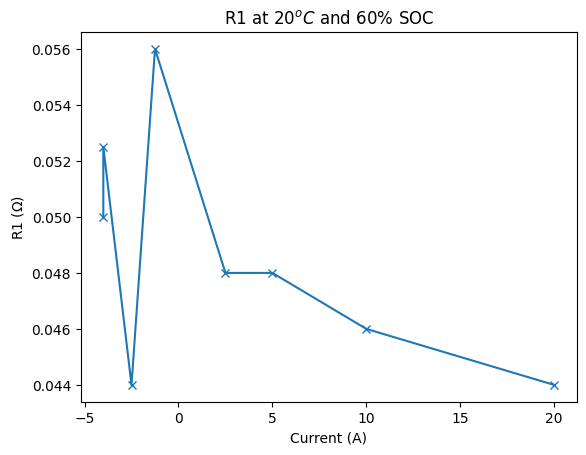

In [14]:
sorted_idx_I = np.argsort(I_peaks[3, :])
plt.plot(I_peaks[3, sorted_idx_I], R1_tab[3, sorted_idx_I], '-x')
plt.xlabel('Current (A)')
plt.ylabel('R1 ($\Omega$)')
plt.title('R1 at $20^oC$ and $60\%$ SOC')
plt.show()

### R1 look-up table

For simplicity, just use 90% - 20% with an interval of 10% for R1 look-up table.

It looks like at the beginning there are two current of -4A, which will raise error for interpolation. It is also weird that for the same current and SOC, the R1 are different. For now, remove the last column for look-up table for simplicity (assumption made).

In [15]:
# interp2d takes input arrays in ascending order
sorted_idx_col = np.argsort(I_peaks[0])
R1_look_up_tab = R1_tab[:, sorted_idx_col]
I_tab = I_peaks[0, sorted_idx_col]

sorted_idx_row = np.argsort(SOC_levels)
R1_look_up_tab = R1_look_up_tab[sorted_idx_row, :]
SOC_tab = SOC_levels[sorted_idx_row]

print(I_tab)
print(SOC_tab)
print(np.round(R1_look_up_tab, 5))

# remove the last column
I_tab = I_tab[1:]
R1_look_up_tab = R1_look_up_tab[:, 1:]

R1_interp_func = interp2d(I_tab, SOC_tab, R1_look_up_tab)

[-4.   -4.   -2.5  -1.25  2.5   5.   10.   20.  ]
[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[[0.05   0.05   0.048  0.048  0.056  0.05   0.051  0.0525]
 [0.05   0.05   0.048  0.04   0.048  0.048  0.048  0.0475]
 [0.05   0.0475 0.048  0.04   0.048  0.048  0.046  0.045 ]
 [0.045  0.0475 0.048  0.048  0.048  0.046  0.046  0.045 ]
 [0.05   0.0525 0.044  0.056  0.048  0.048  0.046  0.044 ]
 [0.05   0.0525 0.048  0.048  0.048  0.046  0.046  0.0435]
 [0.05   0.0525 0.048  0.048  0.048  0.05   0.048  0.044 ]
 [0.05   0.0525 0.048  0.048  0.056  0.05   0.048  0.046 ]]


Now we have R0, R1, C1 as functions of SOC and current, but we only have limited points. For example, if we need R1 at 84 % SOC, we need to linear-interpolate it.

In [16]:
test_I = -6
test_SOC = 0.3

interp_value = R1_interp_func(test_I, test_SOC)

print('Test interpolated value:', interp_value)

Test interpolated value: [0.05]


## Model

### Constants

In [17]:
T0 = 293.15
T_env = 293.15
R = 8.31446261815324        # Gas constant
m = 45.0e-3       # Cell mass 45.0 g

c = 825.0         # Specific heat
h = 10.0          # Heat transfer coefficient

# Cell Dimensions
height = 64.85e-3
radius = 18.33e-3 / 2

# Cell Surface Area
Area = 2*np.pi*radius*height + 2*np.pi*radius**2

In [18]:
def T_change(I, I_R1, R0, R1, dt, T):
    dT = ( (I**2 * R0 + I_R1**2 * R1) * dt - h*Area*(T - T_env)) / (m * c)
    T_new = T + dT
    # T_new = - (h * Area / (m * c)) * (((I**2 * R0 + I_R1**2 * R1) * dt) / (m*c) + T - T_env) + ((I**2 * R0 + I_R1**2 * R1) * dt) / (m * c) + T

    # print (h*Area*(T - T_env) / (m * c))
    # print(R0)
    return T_new

In [19]:
# Temperature depends R0
R0_const = 0.022130114077306542
E = -18682.80693804173

def fit_R0_temp(T):
    R0_val = R0_const * np.exp(-(E / R)*(1/T - 1/T0))
    return R0_val

In [20]:
# Temperature depends R1
R1_const = 0.06381993272009605
b = 0.4983572952818651
c = 0.7350836807623884
# E = -5237.390735707343
E = -16183.5
d1 = 0.014710912236819855
d2 = 37.50311325207411
d3 = 0.00132155691380467

def fit_R1_temp(I, T):
    R1_val = R1_const * np.exp(-((I-b)**2) / (c)) * np.exp(-(E/R) * (1/T - 1/T0)) + d1 * np.exp(-T/d2) + d3
    return R1_val

In [21]:
# Constant C1 :)
C1_const = 197.27991163742004

def fit_C1_temp(T):
    C1_val = C1_const
    return C1_val


In [22]:
# Select which pulse to fit into the first order ECN model
which_SOC = 1
which_pulse = 4
t_seg, I_seg, V_actual_seg = select_pulse(t, I, V_actual, idx_pulse_start, idx_Vss, 
                                          which_SOC, which_pulse, pad_zero=True)

V_pred, T = first_order_ECN_temp(t_seg, I_seg, T0, V_actual_seg, ref_OCV, ref_SOC,
                         fit_R0_temp, fit_R1_temp, fit_C1_temp, T_change)

# print(I_seg)
# print(T)
# print(len(T))
# print(len(V_actual_seg))



-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02213011]
-0.0 [0.02

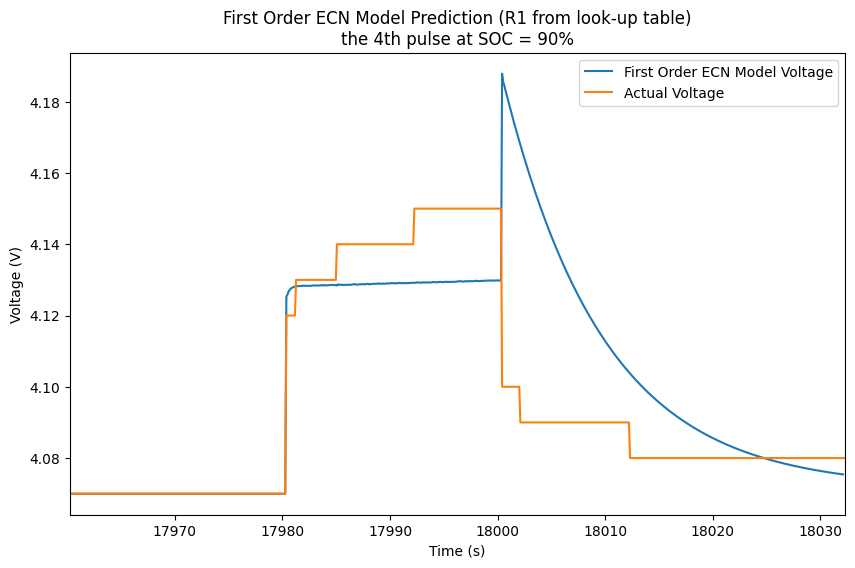

In [23]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_seg[:-2], V_pred[:-2], label='First Order ECN Model Voltage')
ax.plot(t_seg, V_actual_seg, label='Actual Voltage')
ax.legend()
ax.set_xlim([t_seg[0], t_seg[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
pulse_info = 'the {}th pulse at SOC = {:0.0f}%'.format(which_pulse,
                                      SOC_from_idx_map[which_SOC-1]*100)
ax.set_title('First Order ECN Model Prediction (R1 from look-up table)\n'+pulse_info)
plt.show()